In [1]:
import random
#import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import csv
from pgmpy.readwrite import BIFReader
import time
from itertools import combinations
import statistics
import bnlearn as bn
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork
import gc
from utils import *
from ga_operators import *
from loaders import *
import matplotlib.pyplot as plt

In [55]:
data = load_asia_data(sample_size=1000)
d = data.shape[1]

In [56]:
data.head()

,S,L,A,T,E,X,B,D
8445,1,0,0,0,0,0,0,0
980,0,0,0,0,0,0,0,0
9701,0,0,0,0,0,0,0,0
3612,0,0,0,0,0,0,1,0
3282,1,0,0,0,0,0,0,0


In [57]:
# Dictionary to enumarate the nodes
node2idx = {}
for i, node in enumerate(data.columns):
    node2idx[node] = i

idx2node = {}
for i, node in enumerate(data.columns):
    idx2node[i] = node

idx2node

variables = list(data.columns)

var2num = {}
for var, num in zip(variables, range(d)):
    var2num[var] = num
    
num2var = {value: key for key, value in var2num.items()}

In [58]:
# Generate all possible pairs of elements from the variables
edges = list(combinations(variables, 2))

num_edges = len(edges)

# Create a dictionary with enumerated pairs
edge2idx = {edge: index for index, edge in enumerate(edges)}
idx2edge = {index: edge for index, edge in zip(edge2idx.values(), edge2idx.keys()) }

gt_vec = np.zeros(28)

gt_edges = [('A', 'T'), ('T', 'E'), ('E', 'X'), ('E', 'D'), ('S', 'L'), ('S', 'B'), ('B', 'D'), ('L', 'E')]
for edge in gt_edges:
    if edge in edge2idx.keys():
        gt_vec[edge2idx[edge]] = 1
    else:
        gt_vec[edge2idx[edge[::-1]]] = -1

def vec2bayesNet(vector):
    BN = BayesianNetwork()
    for i in range(len(vector)):
        if vector[i] > 0:
            BN.add_edge(idx2edge[i][0], idx2edge[i][1])
            
        if vector[i] < 0:
            BN.add_edge(idx2edge[i][1], idx2edge[i][0])
            
    return BN

gt_from_vec = vec2bayesNet(gt_vec)

In [59]:
gt_from_vec.edges

OutEdgeView([('S', 'L'), ('S', 'B'), ('L', 'E'), ('B', 'D'), ('E', 'X'), ('E', 'D'), ('A', 'T'), ('T', 'E')])

In [60]:
gt_from_vec.adj

AdjacencyView({'S': {'L': {'weight': None}, 'B': {'weight': None}}, 'L': {'E': {'weight': None}}, 'B': {'D': {'weight': None}}, 'E': {'X': {'weight': None}, 'D': {'weight': None}}, 'A': {'T': {'weight': None}}, 'T': {'E': {'weight': None}}, 'X': {}, 'D': {}})

In [61]:
np.abs(structure_score(gt_from_vec, data, scoring_method="bic"))

2265.7178564590577

In [62]:
data.head()

,S,L,A,T,E,X,B,D
8445,1,0,0,0,0,0,0,0
980,0,0,0,0,0,0,0,0
9701,0,0,0,0,0,0,0,0
3612,0,0,0,0,0,0,1,0
3282,1,0,0,0,0,0,0,0


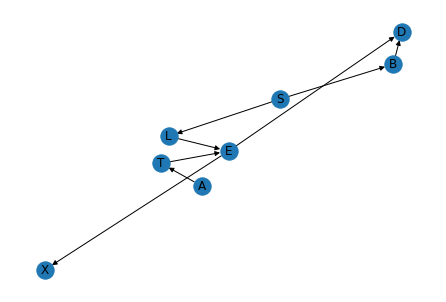

In [63]:
# Ground truth graph
gt_adj = np.zeros([8,8])
gt_adj[0,1] = 1
gt_adj[0,6] = 1
gt_adj[1,4] = 1
gt_adj[2,3] = 1
gt_adj[3,4] = 1
gt_adj[4,5] = 1
gt_adj[4,7] = 1
gt_adj[6,7] = 1

# Create GT in networkx from the adjacency matrix
gt = nx.DiGraph()
for i in range(8):
    for j in range(8):
        if gt_adj[i,j] == 1:
            gt.add_edge(i,j)

# Rename the nodes
gt = nx.relabel_nodes(gt, idx2node)

# Display GT
nx.draw(gt, with_labels=True)

In [64]:
# Print GT adjacency matrix in networkx
print(nx.adjacency_matrix(gt))

# Create adjacency matrix from nx graph
adj_matrix = nx.to_numpy_matrix(gt, nodelist=data.columns)

# Print adjacency matrix
print(adj_matrix)

model = BayesianNetwork(list(gt.edges()))


  (0, 1)	1
  (0, 2)	1
  (1, 3)	1
  (2, 7)	1
  (3, 6)	1
  (3, 7)	1
  (4, 5)	1
  (5, 3)	1
[[0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [65]:
model.edges

OutEdgeView([('S', 'L'), ('S', 'B'), ('L', 'E'), ('B', 'D'), ('E', 'X'), ('E', 'D'), ('A', 'T'), ('T', 'E')])

In [66]:
gt.nodes()

NodeView(('S', 'L', 'B', 'E', 'A', 'T', 'X', 'D'))

In [67]:
for e in gt.edges():
    print(e)

('S', 'L')
('S', 'B')
('L', 'E')
('B', 'D')
('E', 'X')
('E', 'D')
('A', 'T')
('T', 'E')


In [68]:
bn = BayesianNetwork()
for e in gt.edges():
    bn.add_edge(e[0], e[1])

In [69]:
np.abs(structure_score(model, data, scoring_method="bic"))

2265.7178564590577

In [70]:
gt_adj

array([[0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [71]:
gt_bic = BIC(gt, data)
print("GT BIC: ", gt_bic)

GT BIC:  2265.7178564590577


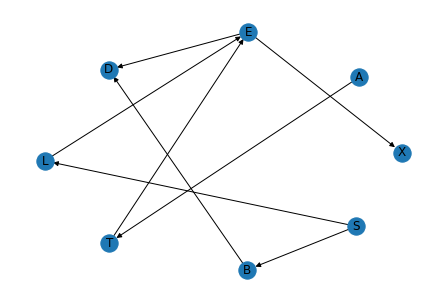

In [72]:
# Create GT in pgmpy
gt_pgmpy = BayesianNetwork()
gt_pgmpy.add_edges_from(gt_edges)

# Display GT
nx.draw(gt_pgmpy, with_labels=True)


In [9]:
np.abs(structure_score(gt_pgmpy, data, scoring_method="bic"))

22295.7456614326

In [2]:
def load_alarm_data(path = '../data/alarm10K.csv'):
    '''
    Loads the Alarm dataset.
    
    Parameters:
    -----------
    path : str
        Path to the Alarm dataset.
    
    Returns:
    --------
    pandas.DataFrame
        The dataset.
    '''
    data = pd.read_csv(path)
    data.rename(columns={
        'HISTORY': 'H',
        'CVP': 'C',
        'PCWP': 'P',
        'HYPOVOLEMIA': 'V',
        'LVEDVOLUME': 'L',
        'LVFAILURE': 'F',
        'STROKEVOLUME': 'S',
        'ERRLOWOUTPUT': 'O',
        'HRBP': 'R',
        'HREKG': 'E',
        'ERRCAUTER': 'A',
        'HRSAT': 'T',
        'INSUFFANESTH': 'I',
        'ANAPHYLAXIS': 'X',
        'TPR': 'Y',
        'EXPCO2': 'Q',
        'KINKEDTUBE': 'K',
        'MINVOL': 'M',
        'FIO2': 'F',
        'PVSAT': 'V',
        'SAO2': 'W',
        'PAP': 'B',
        'PULMEMBOLUS': 'U',
        'SHUNT': 'Z'
    }, inplace=True)

    return data

In [ ]:
def load_adult_data(path='../data/adult.csv'):
    '''
    Loads and processes the adult census income data.
    
    Parameters:
    -----------
    path : str, optional
        Path to the adult census income data file.

    Returns:
    --------
    pandas.DataFrame
        The processed dataset.
    '''
    # Load the data
    data = pd.read_csv(path)
    df = data.rename(columns={
    'Age': 'A',
    ' workclass': 'W',
    ' fnlwgt': 'F',
    ' education': 'ED',
    ' education-num': 'EDN',
    ' marital-status': 'M',
    ' occupation': 'O',
    ' relationship': 'R',
    ' race': 'RA',
    ' sex': 'S',
    ' capital-gain': 'CG',
    ' capital-loss': 'CL',
    ' hours-per-week': 'H',
    ' native-country': 'C',
    ' class': 'I'
    })

    # Create bins for the continuous variables
    df['A'] = pd.cut(df['A'],     bins=5, labels=False)
    df['F'] = pd.cut(df['F'],     bins=5, labels=False)
    df['EDN'] = pd.cut(df['EDN'], bins=5, labels=False)
    df['CG'] = pd.cut(df['CG'],   bins=5, labels=False)
    df['CL'] = pd.cut(df['CL'],   bins=5, labels=False)
    df['H'] = pd.cut(df['H'],     bins=5, labels=False)

    # Process the categorical variables
    df['W'] = df['W'].astype('category').cat.codes
    df['ED'] = df['ED'].astype('category').cat.codes
    df['M'] = df['M'].astype('category').cat.codes
    df['O'] = df['O'].astype('category').cat.codes
    df['R'] = df['R'].astype('category').cat.codes
    df['RA'] = df['RA'].astype('category').cat.codes
    df['S'] = df['S'].astype('category').cat.codes
    df['C'] = df['C'].astype('category').cat.codes
    df['I'] = df['I'].astype('category').cat.codes
    
    return df


In [23]:
df = pd.read_csv('../data/adult.csv')

In [24]:
df.head()

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [25]:
# Rename columns
df = df.rename(columns={
    'Age': 'A',
    ' workclass': 'W',
    ' fnlwgt': 'F',
    ' education': 'ED',
    ' education-num': 'EDN',
    ' marital-status': 'M',
    ' occupation': 'O',
    ' relationship': 'R',
    ' race': 'RA',
    ' sex': 'S',
    ' capital-gain': 'CG',
    ' capital-loss': 'CL',
    ' hours-per-week': 'H',
    ' native-country': 'C',
    ' class': 'I'
})

In [26]:
df.head()

,A,W,F,ED,EDN,M,O,R,RA,S,CG,CL,H,C,I
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [27]:
# Create bins for the continuous variables
df['A'] = pd.cut(df['A'],     bins=5, labels=False)
df['F'] = pd.cut(df['F'],     bins=5, labels=False)
df['EDN'] = pd.cut(df['EDN'], bins=5, labels=False)
df['CG'] = pd.cut(df['CG'],   bins=5, labels=False)
df['CL'] = pd.cut(df['CL'],   bins=5, labels=False)
df['H'] = pd.cut(df['H'],     bins=5, labels=False)

In [28]:
# Process the categorical variables
df['W'] = df['W'].astype('category').cat.codes
df['ED'] = df['ED'].astype('category').cat.codes
df['M'] = df['M'].astype('category').cat.codes
df['O'] = df['O'].astype('category').cat.codes
df['R'] = df['R'].astype('category').cat.codes
df['RA'] = df['RA'].astype('category').cat.codes
df['S'] = df['S'].astype('category').cat.codes
df['C'] = df['C'].astype('category').cat.codes
df['I'] = df['I'].astype('category').cat.codes

In [29]:
# Drop the columns F and EDN
df = df.drop(columns=['F', 'EDN'])

In [30]:
df.head()

,A,W,ED,M,O,R,RA,S,CG,CL,H,C,I
0,1,6,9,4,0,1,4,1,0,0,1,38,0
1,2,5,9,2,3,0,4,1,0,0,0,38,0
2,1,3,11,0,5,1,4,1,0,0,1,38,0
3,2,3,1,2,5,0,2,1,0,0,1,38,0
4,0,3,9,2,9,5,2,0,0,0,1,4,0


In [31]:
df.A.value_counts()

1    12211
0    11460
2     6558
3     2091
4      241
Name: A, dtype: int64

In [32]:
d = df.shape[1]
node2idx = {}
for i, node in enumerate(df.columns):
    node2idx[node] = i

idx2node = {}
for i, node in enumerate(df.columns):
    idx2node[i] = node

idx2node

variables = list(df.columns)

var2num = {}
for var, num in zip(variables, range(d)):
    var2num[var] = num
    
num2var = {value: key for key, value in var2num.items()}

In [33]:
# Create a random DAG for the adult dataset
variables

['A', 'W', 'ED', 'M', 'O', 'R', 'RA', 'S', 'CG', 'CL', 'H', 'C', 'I']

In [34]:
len(variables)

13

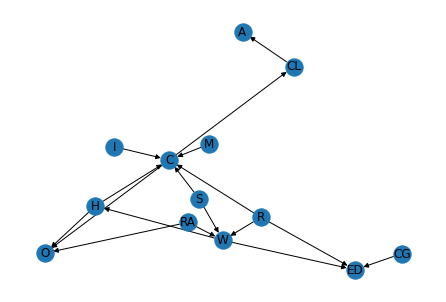

In [35]:
G = createPopulation(1, variables, density_factor=0.1, feasible_only=True)[0]

In [36]:
# Compute BIC score for the random graph
BIC(G, df)

699258.0495799461

In [38]:
# Create ground truth graph
gt = nx.DiGraph()
gt.add_edges_from([['S', 'O'],
                  ['S', 'H'],
                  ['S', 'R'],
                  ['S', 'ED'],
                  ['S', 'RA'],
                  ['R', 'I'],
                  ['R', 'CL'],
                  ['R', 'CG'],
                  ['R', 'H'],
                  ['R', 'W'],
                  ['R', 'A'],
                  ['R', 'M'],
                  ['R', 'RA'],
                  ['A', 'H'],
                  ['A', 'O'],
                  ['A', 'W'],
                  ['A', 'ED'],
                  ['A', 'M'],
                  ['A', 'NC'],
                  ['A', 'RA'],
                  ['A', 'I'],
                  ['H','O'],
                  ['H','W'],
                  ['W', 'O'],
                  ['W', 'ED'],
                  ['W', 'NC'],
                  ['O','CL'],
                  ['O','CG'],
                  ['O','I'],
                  ['O','ED'],
                  ['ED','CG'],
                  ['ED','I'],
                  ['ED','RA'],
                  ['ED','NC'],
                  ['CG', 'CL'],
                  ['CG', 'I'],
                  ['NC','M'],
                  ['NC', 'RA'],
                  ['CL', 'I']]
                  )

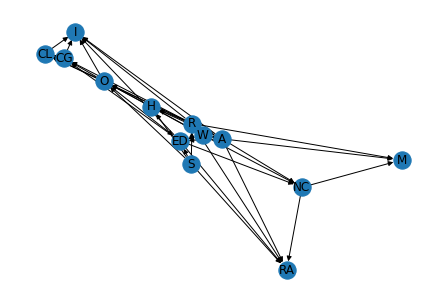

In [40]:
# Draw the ground truth graph
nx.draw(gt, with_labels=True)
